In [1]:
import torch
from torch_geometric.data import Data
from e3nn import o3
from e3nn.nn import Gate, FullyConnectedNet, BatchNorm
from e3nn.o3 import FullyConnectedTensorProduct
from torch_scatter import scatter_sum
from e3nn.util.test import assert_equivariant

In [2]:
def create_random_molecule(num_atoms=5):
    pos = torch.randn(num_atoms, 3)
    edge_index = torch.combinations(torch.arange(num_atoms), r=2).T
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
    return Data(pos=pos, edge_index=edge_index)


In [3]:
data = create_random_molecule()
x = data.pos
edge_index = data.edge_index
edge_index

tensor([[0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 1, 2, 3, 4, 2, 3, 4, 3, 4, 4],
        [1, 2, 3, 4, 2, 3, 4, 3, 4, 4, 0, 0, 0, 0, 1, 1, 1, 2, 2, 3]])

In [4]:
edge_src, edge_dst = edge_index
edge_vec = x[edge_dst] - x[edge_src]
edge_attr = o3.spherical_harmonics(l=1, x=edge_vec, normalize=True, normalization='component')
node_attr = o3.spherical_harmonics(l=1, x=x, normalize=True, normalization='component')

In [5]:
print("Shape of x:", x.shape)
print("Shape of edge_vec:", edge_vec.shape)
print("Shape of edge_attr:", edge_attr.shape)
print("Shape of node_attr:", node_attr.shape)

Shape of x: torch.Size([5, 3])
Shape of edge_vec: torch.Size([20, 3])
Shape of edge_attr: torch.Size([20, 3])
Shape of node_attr: torch.Size([5, 3])


In [6]:
tp = FullyConnectedTensorProduct(
    irreps_in1=o3.Irreps("1o"),
    irreps_in2=o3.Irreps("1o"),
    irreps_out=o3.Irreps("16x0e + 8x1o")
    )
assert_equivariant(tp)

/home/hodaka/miniforge3/envs/ml/lib/python3.9/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/hodaka/miniforge3/envs/ml/lib/python3.9/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/hodaka/miniforge3/envs/ml/lib/python3.9/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/hodaka/miniforge3/envs/ml/lib/python3.9/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/home/hodaka/miniforge3/envs/ml/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotati

{(0, False): tensor([5.2154e-08]), (1, False): tensor([5.9605e-08])}

In [7]:
print("\nInput irreps:")
print("irreps_in1:", tp.irreps_in1)
print("irreps_in2:", tp.irreps_in2)

print("\nOutput irreps:")
print("irreps_out:", tp.irreps_out)

# 期待される入力と出力の次元を確認
print("\nExpected dimensions:")
print("Input 1 dimension:", tp.irreps_in1.dim)
print("Input 2 dimension:", tp.irreps_in2.dim)
print("Output dimension:", tp.irreps_out.dim)


Input irreps:
irreps_in1: 1x1o
irreps_in2: 1x1o

Output irreps:
irreps_out: 16x0e+8x1o

Expected dimensions:
Input 1 dimension: 3
Input 2 dimension: 3
Output dimension: 40


In [8]:
x = tp(node_attr, node_attr)

In [9]:
print(tp.irreps_out)
print(x.shape)

16x0e+8x1o
torch.Size([5, 40])


In [10]:
gate = Gate(
    irreps_scalars=o3.Irreps("8x0e"),
    act_scalars=[torch.tanh],
    irreps_gates=o3.Irreps("8x0e"),  
    act_gates=[torch.tanh],
    irreps_gated=o3.Irreps("8x1o")
)

In [11]:
print("Gate input:", gate.irreps_in)
print("Gate scalars:", gate.irreps_scalars)
print("Gate gates:", gate.irreps_gates)
print("Gate gated:", gate.irreps_gated)
print("Gate output:", gate.irreps_out)

Gate input: 16x0e+8x1o
Gate scalars: 8x0e
Gate gates: 8x0e
Gate gated: 8x1o
Gate output: 8x0e+8x1o


In [12]:
x = gate(x)

In [13]:
class EquivariantNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tp_node = FullyConnectedTensorProduct(
            irreps_in1=o3.Irreps("1o"),
            irreps_in2=o3.Irreps("1o"),
            irreps_out=o3.Irreps("16x0e + 8x1o")
        )
        assert assert_equivariant(self.tp_node)

        self.tp_edge = FullyConnectedTensorProduct(
            irreps_in1=o3.Irreps("1o"),
            irreps_in2=o3.Irreps("1x0e"),
            irreps_out=o3.Irreps("16x0e + 8x1o")
        )
        assert assert_equivariant(self.tp_edge)

        self.gate = Gate(
            irreps_scalars=o3.Irreps("8x0e"),
            act_scalars=[torch.tanh],
            irreps_gates=o3.Irreps("8x0e"),  
            act_gates=[torch.tanh],
            irreps_gated=o3.Irreps("8x1o")
        )
        assert assert_equivariant(self.gate)

        self.linear = o3.Linear(
            self.gate.irreps_out,
            o3.Irreps("1o") 
        )
        assert assert_equivariant(self.linear)

    def forward(self, x, edge_index):
        node_attr = o3.spherical_harmonics(l=1, x=x, normalize=True, normalization='component')
        node_features = self.tp_node(node_attr, node_attr)

        edge_vec = x[edge_index[1]] - x[edge_index[0]]
        edge_length = torch.norm(edge_vec, dim=-1, keepdim=True)
        edge_sh = o3.spherical_harmonics(l=1, x=edge_vec, normalize=True, normalization='component')
        edge_features = self.tp_edge(edge_sh, edge_length)
        sigma = edge_length.mean()

        edge_weight = torch.exp(-edge_length**2 / (2 * sigma**2))
        weighted_edge_features = edge_features * edge_weight
        aggregated_edge_features = scatter_sum(weighted_edge_features, edge_index[0], dim=0, dim_size=x.shape[0])

        updated_node_features = node_features + aggregated_edge_features
        x = self.gate(updated_node_features)
        x = self.linear(x)
        return x


In [14]:
data = create_random_molecule()
model = EquivariantNN()
x = data.pos
y = model(x, data.edge_index)
y

tensor([[-1.7553, -1.3203, -1.4879],
        [ 0.8066,  1.1842, -2.9375],
        [-0.7808, -1.4421,  0.5798],
        [-1.0811,  3.6294,  1.6966],
        [ 2.8106, -2.0512,  2.1490]], grad_fn=<ViewBackward0>)

/home/hodaka/miniforge3/envs/ml/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


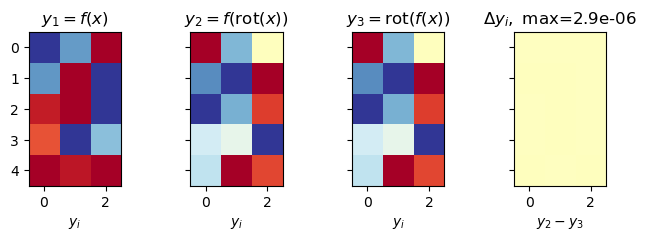

In [15]:
import matplotlib.pyplot as plt

model = EquivariantNN()
data = create_random_molecule()
x = data.pos

R = o3.rand_matrix()

out1 = model(x, edge_index)
x_rotated = torch.einsum('ij,nj->ni', R, x)
out2 = model(x_rotated, edge_index)
out1_rotated = torch.einsum('ij,nj->ni', R, out1)
diff = (out1_rotated - out2).abs().max().item()

fig, axs = plt.subplots(1, 4, figsize=(8,2))
axs[0].imshow(out1.detach().numpy(), cmap='RdYlBu', aspect='equal', vmin=-5, vmax=5)
axs[0].set_title(r"$y_1=f(x)$")
axs[0].set_xlabel(r"$y_i$")
axs[0].label_outer()

axs[1].imshow(out2.detach().numpy(), cmap='RdYlBu', aspect='equal', vmin=-5, vmax=5)
axs[1].set_title(r"$y_2=f(\mathrm{rot}(x))$")
axs[1].set_xlabel(r"$y_i$")
axs[1].label_outer()

axs[2].imshow(out1_rotated.detach().numpy(), cmap='RdYlBu', aspect='equal', vmin=-5, vmax=5)
axs[2].set_title(r"$y_3=\mathrm{rot}(f(x))$")
axs[2].set_xlabel(r"$y_i$")
axs[2].label_outer()

axs[3].imshow((out2 - out1_rotated).detach().numpy(), cmap='RdYlBu', aspect='equal', vmin=-1, vmax=1)
axs[3].set_title(rf"$\Delta y_i,$ max={diff:.1e}")
axs[3].set_xlabel(r"$y_2-y_3$")
axs[3].label_outer()